# CRR - Cox-Ross-Rubinstein binomial model

> Author: Gustavo Monteiro de Athayde  
> Monitor: Sylvio Ximenez de Azevedo Neto - <<sylvioxan@insper.edu.br>>  
> Date: 22/03/2025

In [1]:
# dependencies
from lib import derivatives as dg       # course library

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Global parameters
S0 = 100            # spot price
X = 100             # strike price
rf = 0.02           # risk-free rate
q = 0.03            # dividend yield
vol = 0.4           # volatility

T = 2               # time to maturity

In [3]:
def calc_probability(rf, q, vol, T, steps):

    # up_probability
    return (np.exp((rf-q)*T/steps) - np.exp(-vol*np.sqrt(T/steps))) / (np.exp(vol*np.sqrt(T/steps)) - np.exp(-vol*np.sqrt(T/steps)))

def calc_spot_tree(S0, vol, T, steps):

    # allocate matrix for stock prices
    stock_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    stock_prices.iloc[0, 0] = S0

    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate stock prices
    for i in range(1, steps+1):
        stock_prices.iloc[0, i] = stock_prices.iloc[0, i-1] * up
        for j in range(1, i+1):
            stock_prices.iloc[j, i] = stock_prices.iloc[j-1, i-1] * down

    # replace zeros with NaN
    stock_prices.replace(0, np.nan, inplace=True)

    return stock_prices

In [4]:
prop_ub = calc_probability(rf, q, vol, T, 10)

spot_tree = calc_spot_tree(S0, vol, T, 10)

In [5]:
prop_ub

np.float64(0.44984260714357704)

In [6]:
spot_tree

,0,1,2,3,4,5,6,7,8,9,10
0,100.0,119.588373,143.013790,171.027866,204.529443,244.593433,292.505308,349.802340,418.322929,500.265586,598.259477
1,NaN,83.620169,100.000000,119.588373,143.013790,171.027866,204.529443,244.593433,292.505308,349.802340,418.322929
2,NaN,NaN,69.923327,83.620169,100.000000,119.588373,143.013790,171.027866,204.529443,244.593433,292.505308
3,NaN,NaN,NaN,58.470004,69.923327,83.620169,100.000000,119.588373,143.013790,171.027866,204.529443
4,NaN,NaN,NaN,NaN,48.892716,58.470004,69.923327,83.620169,100.000000,119.588373,143.013790
5,NaN,NaN,NaN,NaN,NaN,40.884172,48.892716,58.470004,69.923327,83.620169,100.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,34.187414,40.884172,48.892716,58.470004,69.923327
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.587573,34.187414,40.884172,48.892716
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.904977,28.587573,34.187414
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.989382,23.904977


In [7]:
def ccr_eur_call(S0, X, rf, q, vol, T, steps):

    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, stock_prices.iloc[:, steps] - X)

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1])

    return option_prices


In [8]:
ccr_eur_call(S0, X, rf, q, vol, T, 4)

,0,1,2,3,4
0,18.975243,37.942067,72.842030,131.137434,209.990309
1,0.000000,5.510362,13.218509,31.709169,76.065417
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
def ccr_eur_put(S0, X, rf, q, vol, T, steps):

    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, X - stock_prices.iloc[:, steps])

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1])

    return option_prices

In [10]:
ccr_eur_put(S0, X, rf, q, vol, T, 4)

,0,1,2,3,4
0,20.877734,8.135654,0.000000,0.000000,0.000000
1,0.000000,30.507282,14.193823,0.000000,0.000000
2,0.000000,0.000000,42.901403,24.763173,0.000000
3,0.000000,0.000000,0.000000,56.837809,43.202929
4,0.000000,0.000000,0.000000,0.000000,67.740927


In [11]:
def ccr_amer_call(S0, X, rf, q, vol, T, steps):
    
    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, stock_prices.iloc[:, steps] - X)

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.maximum(np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1]), stock_prices.iloc[j, i] - X)

    return option_prices

In [12]:
ccr_amer_call(S0, X, rf, q, vol, T, 2)

,0,1,2
0,18.762794,49.18247,122.554093
1,0.000000,0.00000,0.000000
2,0.000000,0.00000,0.000000


In [13]:
def ccr_amer_put(S0, X, rf, q, vol, T, steps):
    
    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, X - stock_prices.iloc[:, steps])

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.maximum(np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1]), X - stock_prices.iloc[j, i])

    return option_prices

In [14]:
ccr_amer_put(S0, X, rf, q, vol, T, 2)

,0,1,2
0,19.738684,0.000000,0.000000
1,0.000000,32.968958,0.000000
2,0.000000,0.000000,55.067104


In [23]:
def calc_prices(S0, X, rf, q, vol, T, steps):

    # calculate option prices for each step and accumulate them into a dataframe
    df = pd.DataFrame(np.zeros((steps, 6)))
    df.columns = ['BS_Call', 'BS_Put', 'European Call', 'European Put', 'American Call', 'American Put']
    
    for step in range(1, steps+1):        
        
        df_eur_call = ccr_eur_call(S0, X, rf, q, vol, T, step)
        df_eur_put = ccr_eur_put(S0, X, rf, q, vol, T, step)
        df_amer_call = ccr_amer_call(S0, X, rf, q, vol, T, step)
        df_amer_put = ccr_amer_put(S0, X, rf, q, vol, T, step)

        df.iloc[step-1, 2] = df_eur_call.iloc[0, 0]
        df.iloc[step-1, 3] = df_eur_put.iloc[0, 0]
        df.iloc[step-1, 4] = df_amer_call.iloc[0, 0]
        df.iloc[step-1, 5] = df_amer_put.iloc[0, 0]

        # callculate bs price        
        bs_call = dg.bs76_call_option(S0, X, T, q, rf, vol)
        df.iloc[step-1, 0] = bs_call

        bs_put = dg.bs76_put_option(S0, X, T, q, rf, vol)
        df.iloc[step-1, 1] = bs_put

    return df
    

In [28]:
df = calc_prices(S0, X, rf, q, vol, T, 100)

In [29]:
df

,BS_Call,BS_Put,European Call,European Put,American Call,American Put
0,20.246829,22.14932,25.259673,27.162163,25.259673,27.162163
1,20.246829,22.14932,17.836194,19.738684,18.762794,19.738684
2,20.246829,22.14932,21.952830,23.855321,22.357030,23.955304
3,20.246829,22.14932,18.975243,20.877734,19.730721,20.976797
4,20.246829,22.14932,21.265791,23.168281,21.689429,23.272858
...,...,...,...,...,...,...
95,20.246829,22.14932,20.191725,22.094216,20.622287,22.194803
96,20.246829,22.14932,20.298533,22.201023,20.715249,22.300173
97,20.246829,22.14932,20.192848,22.095339,20.623100,22.195908
98,20.246829,22.14932,20.297487,22.199978,20.714211,22.299133


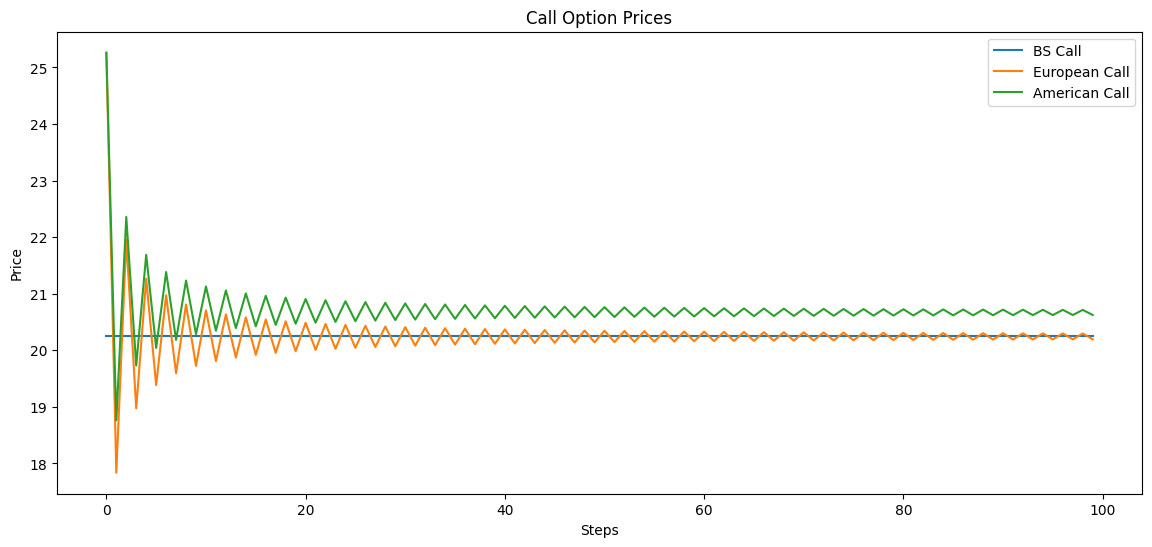

In [30]:
# plot call prices
plt.figure(figsize=(14, 6))
plt.plot(df[['BS_Call', 'European Call', 'American Call']])
plt.title('Call Option Prices')
plt.xlabel('Steps')
plt.ylabel('Price')
plt.legend(['BS Call', 'European Call', 'American Call'])
plt.show()

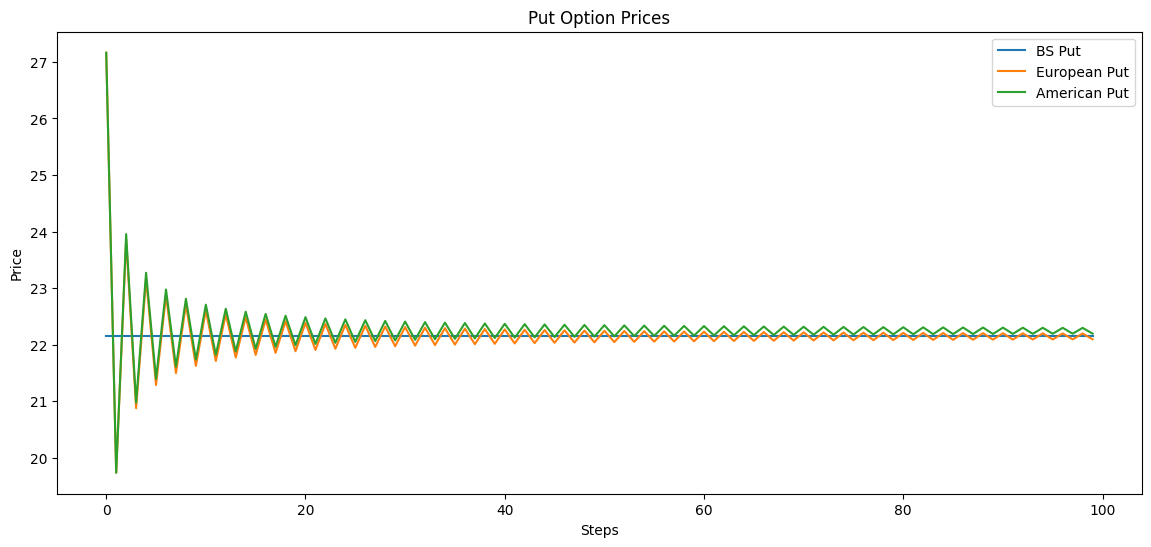

In [31]:
# plot put prices
plt.figure(figsize=(14, 6))
plt.plot(df[['BS_Put', 'European Put', 'American Put']])
plt.title('Put Option Prices')
plt.xlabel('Steps')
plt.ylabel('Price')
plt.legend(['BS Put', 'European Put', 'American Put'])
plt.show()